<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Финальный-вывод" data-toc-modified-id="Финальный-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Финальный вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Разложим временной ряд на тренд и сезоную составляющие

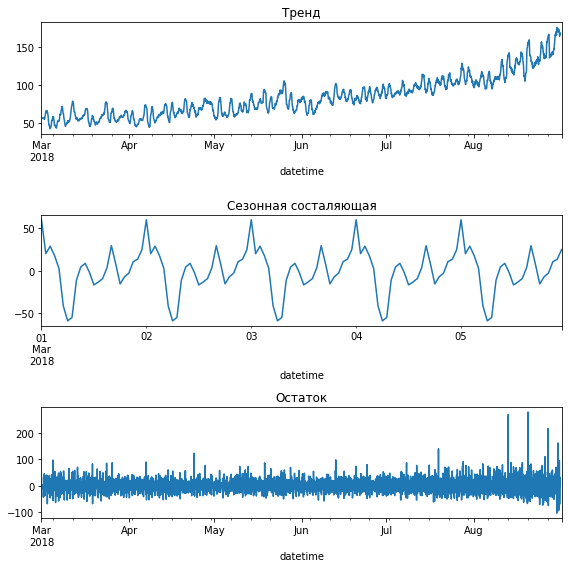

In [4]:
decomposed = seasonal_decompose(df)
 
plt.figure(figsize=(8, 8)) 
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Сезонная состаляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()


Исходя из графиков определеям календарные признаки будем закладывать в модель:
1. Месяц  и число (по графику тренда)
2. Часы  (по графику сезонности)
3. День недели (по графику остатков)

Мы делаем прогноз на сутки, поэтому скользящее среднее равно 24 часам

Количество лагов будем подбирать перебором(1 час, 3часа, 6 часов, 12 часов, 24 часа) в цикле
Для этого используем функцию создания признаков, результатотм которой будет расчет метрики RSME логистической регресии:

 На этом этапе я хочу подобрать значение количества лагов и выбрать его при лучшем качестве кроссвалидации.
Использовать кросс-валидацию будем с параметором TimeSeriesSplit.
Учитывая твой последующий комментарий, результат расчета функции будем сохранять в отдельный список data_temp, а не перезаписывть глобальную переменную df

In [5]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    features_train = train.drop('num_orders',axis=1)
    features_test = test.drop('num_orders',axis=1)
    target_train = train['num_orders']
    target_test = test['num_orders']

    model = LinearRegression()
    rsme = -cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
    print(f'RSME = {rsme.round(2)} при lag= {max_lag}')
    return data

In [6]:
lags_list=[1,3,6,12,24]
data_temp =[]
df_new = df.copy()
for i in range(len(lags_list)):
    data_temp.append(make_features(df_new, lags_list[i], 24))
    display(data_temp[i].head())

RSME = 31.54 при lag= 1


,num_orders,month,day,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,NaN


RSME = 31.46 при lag= 3


,num_orders,month,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN,124.0,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,NaN,85.0,124.0
2018-03-01 04:00:00,43,3,1,4,3,66.0,NaN,71.0,85.0


RSME = 31.48 при lag= 6


,num_orders,month,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,NaN,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,NaN,71.0,85.0,124.0,NaN,NaN


RSME = 31.36 при lag= 12


,num_orders,month,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,NaN,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,NaN,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


RSME = 26.94 при lag= 24


,num_orders,month,day,hour,dayofweek,lag_1,rolling_mean,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,NaN,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,NaN,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,NaN,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Минимальное значение RSME при lag= 24, используем это значение параметра для дальнейшего исследования.

 На этом этапе я убрал повторяющуюся ранее функцию make_features. А для выбора необходимого датафрейма обратился к элементу списка, соответствующему значению lag=12, т.е. data_temp[4]. Разделим данные на обучающую и тестовую выборки(доля тестовой по условию 10%)

In [8]:
train, test = train_test_split(data_temp[4], shuffle=False, test_size=0.1)
train = train.dropna()
    
features_train = train.drop('num_orders',axis=1)
features_test = test.drop('num_orders',axis=1)
target_train = train['num_orders']
target_test = test['num_orders']
print(features_train.shape,features_test.shape,target_train.shape,target_test.shape)


(3950, 29) (442, 29) (3950,) (442,)


## Обучение

Произведем обученине моделей. Для подбора параметров используем инструмент GridSearchCV.
Параметры моделей заранее подобраны таким образом, чтобы время обучения было минимальным при рассчитанной минимальной RSME.

Начинаем с метода <b>Дерево решений</b>:

In [9]:
model_dt= DecisionTreeRegressor(random_state=12345)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(20,30)
}
gsearch = GridSearchCV(model_dt, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
dt_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE: {-dt_model.best_score_} при параметрах {dt_model.best_params_}')

Лучшая RMSE: 28.776013240838164 при параметрах {'max_depth': 15, 'min_samples_leaf': 27}


<b>Случайный Лес:</b>

In [10]:
model_rf= RandomForestRegressor(random_state=12345)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(2,3)
}
gsearch = GridSearchCV(model_rf, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
rf_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE: {-rf_model.best_score_} при параметрах ,{rf_model.best_params_}')

Лучшая RMSE: 25.341199962902714 при параметрах ,{'max_depth': 15, 'min_samples_leaf': 2}


<b>Линейная регрессия:</b>

In [11]:
model_lr = LinearRegression() 
model_lr.fit(features_train, target_train)
 
predictions = model_lr.predict(features_test)  
print("RMSE:",mean_squared_error(target_test,predictions,squared= False))

RMSE: 45.81094888906951


<b>LightGBM:</b>

In [12]:
model_lgbm= LGBMRegressor(random_state=12345, n_jobs=2)

param_grid = {
    "max_depth" : range(11,12),
    "n_estimators" : range(56,57)
}

gsearch = GridSearchCV(model_lgbm, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
lgb_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE: {-lgb_model.best_score_} при параметрах ,{lgb_model.best_params_}')

Лучшая RMSE: 24.87613969873619 при параметрах ,{'max_depth': 11, 'n_estimators': 56}


Cравним RSME, проведя кроссвалидацию на трейне по каждой из рассматриваемых моделей:

In [13]:
RSME_dt = -cross_val_score(model_dt, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
RSME_rf = -cross_val_score(model_rf, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
RSME_lr = -cross_val_score(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
RSME_lgbm = -cross_val_score(lgb_model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
print(RSME_dt,RSME_rf,RSME_lr,RSME_lgbm)

35.473571300220584 25.25233345532437 26.941338470233404 24.87613969873619


Таким образом мы получили минимальную метрику RSME= 24.876 при обучении модели методом LightGBM.

## Тестирование

Проведем финальные тесты, определим RSME на тестовых данных

In [14]:
dt_model_test = dt_model.fit(features_train,target_train)
dt_predictions = dt_model_test.predict(features_test)
RSME_dt_test = mean_squared_error(target_test, dt_predictions,squared= False)

In [15]:
rf_model_test = rf_model.fit(features_train,target_train)
rf_predictions = rf_model_test.predict(features_test)
RSME_rf_test = mean_squared_error(target_test, rf_predictions,squared= False)

In [16]:
lr_model_test = model_lr.fit(features_train,target_train)
lr_predictions = lr_model_test.predict(features_test)
RSME_lr_test = mean_squared_error(target_test, lr_predictions,squared= False)

In [17]:
lgb_model_test = lgb_model.fit(features_train,target_train)
lgb_predictions = lgb_model_test.predict(features_test)
RSME_lgb_test = mean_squared_error(target_test, lgb_predictions,squared= False)

In [18]:
print(RSME_dt_test,RSME_rf_test,RSME_lr_test,RSME_lgb_test)

56.188282345206964 43.11046723577575 45.81094888906951 41.65291089352744


Визуализируем предскания по всем рассмотренным моделям.

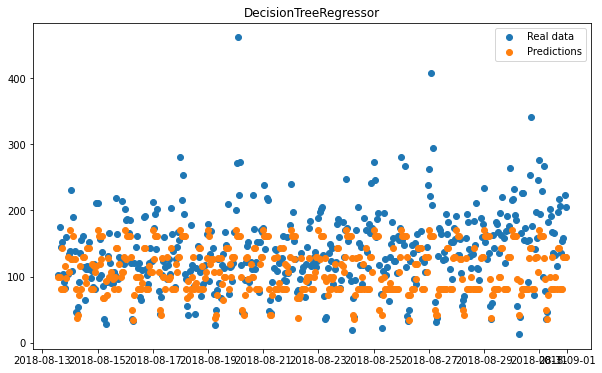

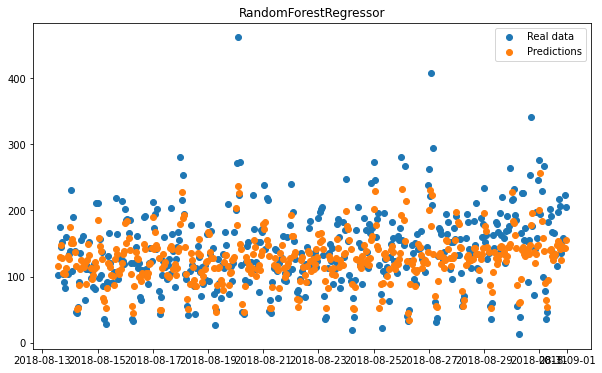

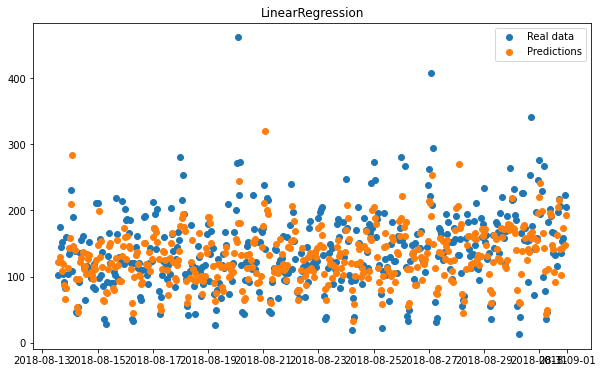

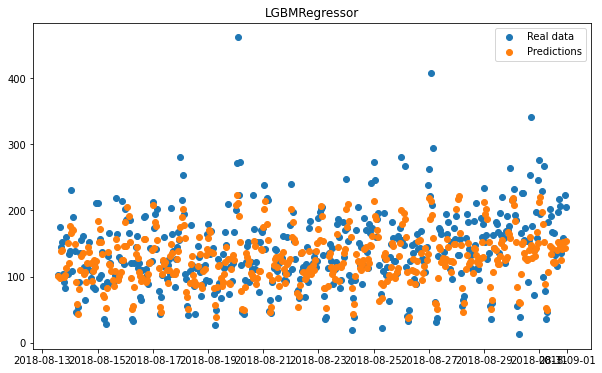

In [19]:
prediction_list = [dt_predictions,rf_predictions,lr_predictions,lgb_predictions]
model_list = ['DecisionTreeRegressor','RandomForestRegressor','LinearRegression','LGBMRegressor']
for pred in range(4):
    plt.figure(figsize=(10, 6)) 
    plt.scatter(y=target_test, x=target_test.index, label='Real data')
    plt.scatter(y=prediction_list[pred], x=target_test.index, label='Predictions')
    plt.legend(loc='upper right')
    plt.title(model_list[pred])
    plt.show()

## Финальный вывод

В ходе проекта были обработаны данные о заказах такси. Для прогноза количества заказов такси были построены 4 модели предскания.
Самой эффективной моделью, которая показала минимальную метрику RSME(41,65) является модель градиентного бустинга библиотеки LightGBM, о чем свидетелствует финальный график. Требование о значении метрики RMSE (не более 48) выполнено.